In [1]:
'''
本文件演示了Reformer模型的训练和预测过程
'''
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import os
import tqdm
import random
import sys
import os
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("muted")

# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [2]:
from models.RNN import RNN, LSTM, GRU
from models.CNN import CNN, TCN
from models.MLP import MLP
from models.transformer import Transformer, iTransformer, PatchTST, Reformer, Informer
from models.Linear import LLinear, DLinear, NLinear
from models.stat import Identical, ExponentialMovingAverage, SVR
from flight_data_prediction.utils import FitHistory

# 超参数
num_epochs = 10  # 训练的轮数
learning_rate = 0.001 # 学习率
input_len = 64  # 输入长度
output_len = 24  # 输出长度
label_len = 8 # 标签长度
input_channels = 13  # 输入通道数
output_channels = 13  # 输出通道数
batch_size = 32  # 批大小
#device = 'cpu'  # 设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 实例化模型、损失函数、评估函数和优化器
MODEL = Reformer(
    input_len=input_len, output_len=output_len, input_channels=input_channels, output_channels=output_channels, label_len=label_len,
    ).to(device)
loss_func = nn.MSELoss()
metric_func=nn.L1Loss()
optimizer = optim.Adam(MODEL.parameters(), lr=learning_rate)
history=FitHistory()
print('Model parameters: ', sum(p.numel() for p in MODEL.parameters()))

Model parameters:  276045


In [3]:
import flight_data_prediction.data_preprocessing as dp

mat_paths=dp.get_mat_paths(data_dir="D:\\NASA_flight_Dataset\\Data_Download")
var_names=['ALT', 'ALTR', "TAS", 'GS', 'AOA1', 'AOA2', 'PTCH', 'WS', "WD", 'SAT', 'TAT', 'PI', 'PT']
# 以下序号代表经简单数据清洗后认为质量较高的mat文件，共1462个
indices=[6, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 40, 41, 42, 44, 46, 47, 48, 49, 50, 53, 54, 57, 58, 66, 67, 68, 69, 70, 80, 81, 84, 85, 86, 87, 89, 92, 93, 95, 96, 97, 98, 99, 105, 108, 110, 113, 114, 115, 116, 117, 120, 121, 122, 123, 124, 125, 127, 128, 129, 131, 137, 138, 142, 143, 144, 146, 147, 148, 149, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 168, 170, 171, 173, 174, 175, 177, 179, 181, 182, 194, 195, 196, 197, 202, 203, 204, 206, 207, 208, 211, 212, 213, 216, 217, 218, 219, 220, 221, 222, 223, 227, 229, 231, 232, 233, 239, 240, 243, 244, 245, 246, 249, 250, 252, 253, 255, 256, 257, 258, 260, 261, 262, 264, 270, 271, 272, 273, 276, 277, 279, 281, 282, 283, 288, 292, 293, 294, 295, 296, 297, 298, 301, 302, 304, 305, 306, 307, 308, 309, 310, 312, 313, 314, 316, 319, 320, 323, 324, 325, 330, 331, 332, 333, 339, 340, 343, 344, 348, 371, 378, 379, 380, 381, 382, 385, 386, 387, 388, 390, 391, 394, 395, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 413, 414, 415, 416, 417, 418, 420, 421, 423, 424, 426, 432, 433, 434, 435, 444, 445, 446, 447, 451, 452, 453, 454, 459, 460, 461, 462, 463, 465, 466, 469, 470, 471, 472, 483, 484, 485, 486, 490, 491, 493, 494, 495, 499, 500, 502, 503, 504, 507, 509, 511, 513, 514, 515, 516, 517, 523, 524, 525, 528, 529, 530, 531, 532, 533, 536, 537, 538, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 556, 557, 558, 560, 561, 562, 563, 564, 568, 570, 575, 577, 578, 579, 580, 581, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599, 600, 601, 604, 605, 606, 607, 610, 611, 612, 614, 615, 619, 620, 621, 623, 624, 626, 627, 628, 631, 632, 633, 642, 644, 647, 650, 651, 652, 654, 658, 659, 660, 661, 662, 663, 664, 665, 667, 668, 669, 671, 672, 673, 675, 677, 679, 680, 681, 683, 684, 685, 687, 689, 690, 691, 692, 693, 695, 697, 698, 699, 703, 704, 705, 706, 707, 708, 709, 710, 711, 713, 714, 715, 718, 720, 721, 722, 729, 732, 733, 734, 735, 737, 739, 743, 744, 745, 746, 749, 750, 751, 752, 754, 756, 759, 760, 761, 763, 764, 766, 771, 772, 773, 774, 775, 776, 778, 780, 784, 785, 787, 789, 795, 796, 797, 803, 806, 807, 812, 813, 815, 816, 817, 818, 820, 822, 826, 827, 828, 829, 833, 836, 837, 841, 842, 843, 845, 846, 847, 855, 856, 858, 859, 860, 861, 862, 868, 869, 870, 872, 876, 877, 886, 887, 888, 889, 890, 891, 892, 896, 897, 898, 899, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 912, 913, 914, 915, 916, 917, 918, 920, 924, 925, 926, 928, 933, 935, 937, 938, 940, 941, 943, 945, 947, 948, 950, 951, 955, 959, 960, 961, 962, 965, 967, 968, 969, 974, 978, 982, 983, 984, 986, 987, 991, 992, 1005, 1006, 1007, 1010, 1011, 1012, 1013, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1029, 1030, 1031, 1032, 1033, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1060, 1061, 1066, 1069, 1073, 1074, 1081, 1082, 1087, 1088, 1090, 1093, 1096, 1097, 1098, 1099, 1100, 1102, 1103, 1108, 1111, 1112, 1113, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1145, 1146, 1148, 1149, 1150, 1151, 1152, 1153, 1155, 1157, 1158, 1159, 1161, 1162, 1165, 1167, 1168, 1169, 1171, 1172, 1173, 1174, 1175, 1178, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1193, 1195, 1197, 1198, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1213, 1217, 1218, 1219, 1220, 1224, 1225, 1226, 1228, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1250, 1251, 1252, 1257, 1260, 1261, 1264, 1265, 1269, 1270, 1271, 1272, 1274, 1275, 1276, 1277, 1278, 1279, 1282, 1284, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1299, 1300, 1302, 1303, 1304, 1306, 1308, 1311, 1312, 1313, 1314, 1315, 1318, 1320, 1322, 1323, 1324, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1338, 1339, 1340, 1342, 1343, 1344, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1358, 1359, 1360, 1362, 1363, 1365, 1366, 1369, 1370, 1371, 1373, 1375, 1376, 1377, 1379, 1382, 1383, 1386, 1387, 1388, 1390, 1391, 1393, 1394, 1395, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1411, 1412, 1413, 1414, 1417, 1420, 1421, 1422, 1423, 1424, 1425, 1429, 1430, 1433, 1434, 1435, 1440, 1441, 1442, 1445, 1446, 1447, 1448, 1449, 1450, 1458, 1459, 1462, 1463, 1466, 1470, 1474, 1476, 1477, 1478, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1494, 1495, 1496, 1497, 1500, 1501, 1505, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1525, 1526, 1530, 1531, 1535, 1536, 1539, 1540, 1541, 1543, 1544, 1546, 1549, 1550, 1551, 1552, 1553, 1559, 1560, 1563, 1564, 1566, 1569, 1570, 1572, 1573, 1574, 1576, 1577, 1580, 1581, 1584, 1585, 1586, 1587, 1589, 1590, 1591, 1596, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1616, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1626, 1628, 1629, 1630, 1632, 1635, 1636, 1637, 1638, 1639, 1640, 1644, 1645, 1647, 1648, 1649, 1653, 1654, 1655, 1657, 1665, 1666, 1667, 1668, 1669, 1671, 1674, 1675, 1677, 1678, 1679, 1680, 1684, 1687, 1690, 1691, 1693, 1694, 1698, 1699, 1700, 1701, 1705, 1706, 1707, 1708, 1711, 1712, 1715, 1716, 1717, 1718, 1719, 1720, 1722, 1723, 1725, 1726, 1730, 1731, 1732, 1733, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1746, 1748, 1749, 1750, 1751, 1752, 1755, 1757, 1758, 1759, 1760, 1761, 1762, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1775, 1776, 1778, 1779, 1780, 1781, 1785, 1786, 1787, 1789, 1790, 1792, 1794, 1796, 1797, 1798, 1805, 1806, 1808, 1810, 1811, 1812, 1813, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1829, 1830, 1833, 1834, 1835, 1837, 1844, 1847, 1853, 1854, 1855, 1859, 1863, 1864, 1865, 1866, 1867, 1869, 1870, 1873, 1874, 1875, 1877, 1881, 1883, 1884, 1886, 1887, 1891, 1895, 1896, 1903, 1906, 1908, 1909, 1910, 1911, 1912, 1913, 1916, 1917, 1918, 1921, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1933, 1934, 1935, 1936, 1937, 1939, 1940, 1941, 1947, 1948, 1951, 1952, 1954, 1955, 1956, 1960, 1961, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1973, 1974, 1975, 1977, 1978, 1979, 1980, 1981, 1983, 1987, 1988, 1990, 1992, 1995, 1996, 1997, 1998, 2001, 2003, 2005, 2006, 2007, 2010, 2011, 2012, 2014, 2017, 2019, 2020, 2021, 2027, 2028, 2029, 2032, 2033, 2034, 2036, 2037, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2061, 2062, 2063, 2064, 2065, 2066, 2068, 2069, 2070, 2072, 2074, 2075, 2077, 2078, 2079, 2081, 2083, 2084, 2085, 2086, 2089, 2090, 2091, 2092, 2093, 2095, 2097, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2116, 2118, 2119, 2120, 2121, 2123, 2126, 2128, 2132, 2133, 2135, 2136, 2137, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2147, 2148, 2149, 2150, 2151, 2153, 2154, 2156, 2157, 2158, 2159, 2160, 2161, 2163, 2164, 2165, 2166, 2168, 2169, 2170, 2172, 2173, 2174, 2175, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2188, 2189, 2190, 2192, 2193, 2194, 2195, 2196, 2200, 2202, 2203, 2205, 2206, 2207, 2208, 2209, 2214, 2215, 2217, 2221, 2222, 2223, 2226, 2228, 2234, 2236, 2238, 2239, 2241, 2242, 2244, 2247, 2248, 2249, 2250, 2253, 2255, 2262, 2271, 2272, 2273, 2274, 2276, 2278, 2280, 2282, 2284, 2286, 2288, 2291, 2292, 2295, 2296, 2297, 2299, 2300, 2302, 2303, 2304, 2306, 2307, 2308, 2311, 2312, 2314, 2315, 2316, 2317, 2319, 2320, 2321, 2322, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2333, 2334, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2356, 2362, 2364, 2369, 2375, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2388, 2389, 2391, 2392, 2393, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2404, 2405, 2408, 2418, 2419, 2423, 2424, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2437, 2438, 2439, 2441, 2442, 2443, 2445, 2446, 2447, 2448, 2455, 2458, 2461, 2462, 2463, 2464, 2466, 2467, 2468, 2470, 2471, 2472, 2474, 2475, 2478, 2480, 2481, 2482, 2483, 2484, 2485, 2487, 2491, 2492, 2494, 2496, 2497, 2498, 2499]
indices=indices[:64] # 可以不取完整数据集，仅使用部分mat文件
X, Y, X_grouped, Y_grouped = dp.get_XY(mat_paths=mat_paths,
                                       input_len=input_len,
                                       output_len=output_len,
                                       label_len=label_len,
                                       var_names=var_names,
                                       indices=indices,
                                       verbose=1)
train_loader, val_loader, test_loader = dp.get_XY_loaders(X, Y, batch_size=batch_size)




GenerateX: 10th mat completed.
GenerateX: 20th mat completed.
GenerateX: 30th mat completed.
GenerateX: 40th mat completed.
GenerateX: 50th mat completed.
GenerateX: 60th mat completed.
len(X_grouped): 64
len(Y_grouped): 64
X shape:  (22533, 64, 13)
Y shape:  (22533, 24, 13)
Train dataset size: X: (15773, 64, 13); Y: (15773, 24, 13)
Val dataset size: X: (2253, 64, 13); Y: (2253, 24, 13)
Test dataset size: X: (4506, 64, 13); Y: (4506, 24, 13)


 10%|█         | 1/10 [00:47<07:11, 47.91s/it]

Epoch [ 1  /10], Time: 47.9109s, Loss: 0.1412, Metric: 0.2046, Val Loss: 0.0767, Val Metric: 0.1411


 20%|██        | 2/10 [01:31<06:00, 45.12s/it]

Epoch [ 2  /10], Time: 43.1589s, Loss: 0.0819, Metric: 0.1499, Val Loss: 0.0652, Val Metric: 0.1258


 30%|███       | 3/10 [02:14<05:10, 44.38s/it]

Epoch [ 3  /10], Time: 43.5083s, Loss: 0.0742, Metric: 0.1402, Val Loss: 0.0733, Val Metric: 0.1363


 40%|████      | 4/10 [03:16<05:08, 51.38s/it]

Epoch [ 4  /10], Time: 62.1120s, Loss: 0.0648, Metric: 0.1271, Val Loss: 0.0543, Val Metric: 0.1169


 50%|█████     | 5/10 [04:25<04:48, 57.64s/it]

Epoch [ 5  /10], Time: 68.7310s, Loss: 0.0683, Metric: 0.1323, Val Loss: 0.0514, Val Metric: 0.1125


 60%|██████    | 6/10 [05:33<04:04, 61.19s/it]

Epoch [ 6  /10], Time: 68.0896s, Loss: 0.0603, Metric: 0.1205, Val Loss: 0.0466, Val Metric: 0.0955


 70%|███████   | 7/10 [06:42<03:11, 63.70s/it]

Epoch [ 7  /10], Time: 68.8466s, Loss: 0.0668, Metric: 0.1285, Val Loss: 0.0492, Val Metric: 0.1035


 80%|████████  | 8/10 [07:51<02:10, 65.27s/it]

Epoch [ 8  /10], Time: 68.6486s, Loss: 0.0585, Metric: 0.1169, Val Loss: 0.0443, Val Metric: 0.1004


 90%|█████████ | 9/10 [08:37<00:59, 59.47s/it]

Epoch [ 9  /10], Time: 46.7038s, Loss: 0.0539, Metric: 0.1111, Val Loss: 0.0495, Val Metric: 0.1103


100%|██████████| 10/10 [09:23<00:00, 56.39s/it]

Epoch [ 10 /10], Time: 46.1463s, Loss: 0.0634, Metric: 0.1235, Val Loss: 0.1187, Val Metric: 0.1584
Total Time: 563.8558s


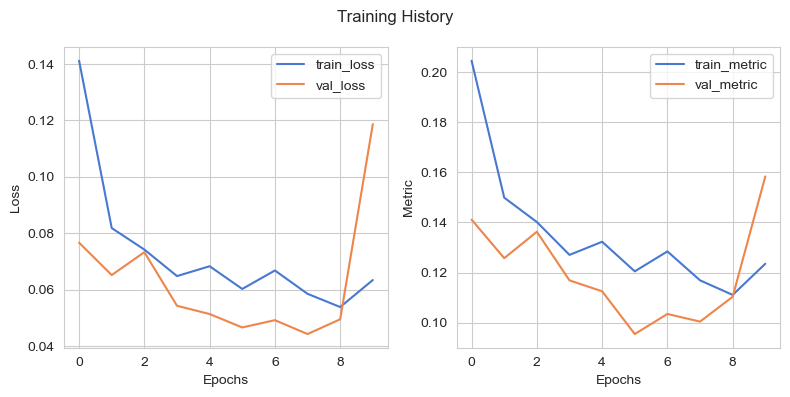

Number of epochs:  10
Training time:     563.8558s
Training loss:     0.0634
Training metric:   0.1235
Validation loss:   0.1187
Validation metric: 0.1584


In [4]:
from flight_data_prediction.utils import train, plot_predictions
# 训练模型
history.update(
            *train(MODEL, train_loader, val_loader, optimizer,
                loss_func=nn.MSELoss(),
                metric_func=nn.L1Loss(),
                num_epochs=10,
                device=device,
                verbose=1)
            )
history.plot()
history.summary()


e:\生活收藏\python项目\deep-learning-models\scripts\..\flight_data_prediction\utils.py:279: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  X_to_predict=torch.Tensor(X_to_predict).to(device) # X_to_predict: torch.Tensor. Shape: (num_batches, input_len, input_channels)


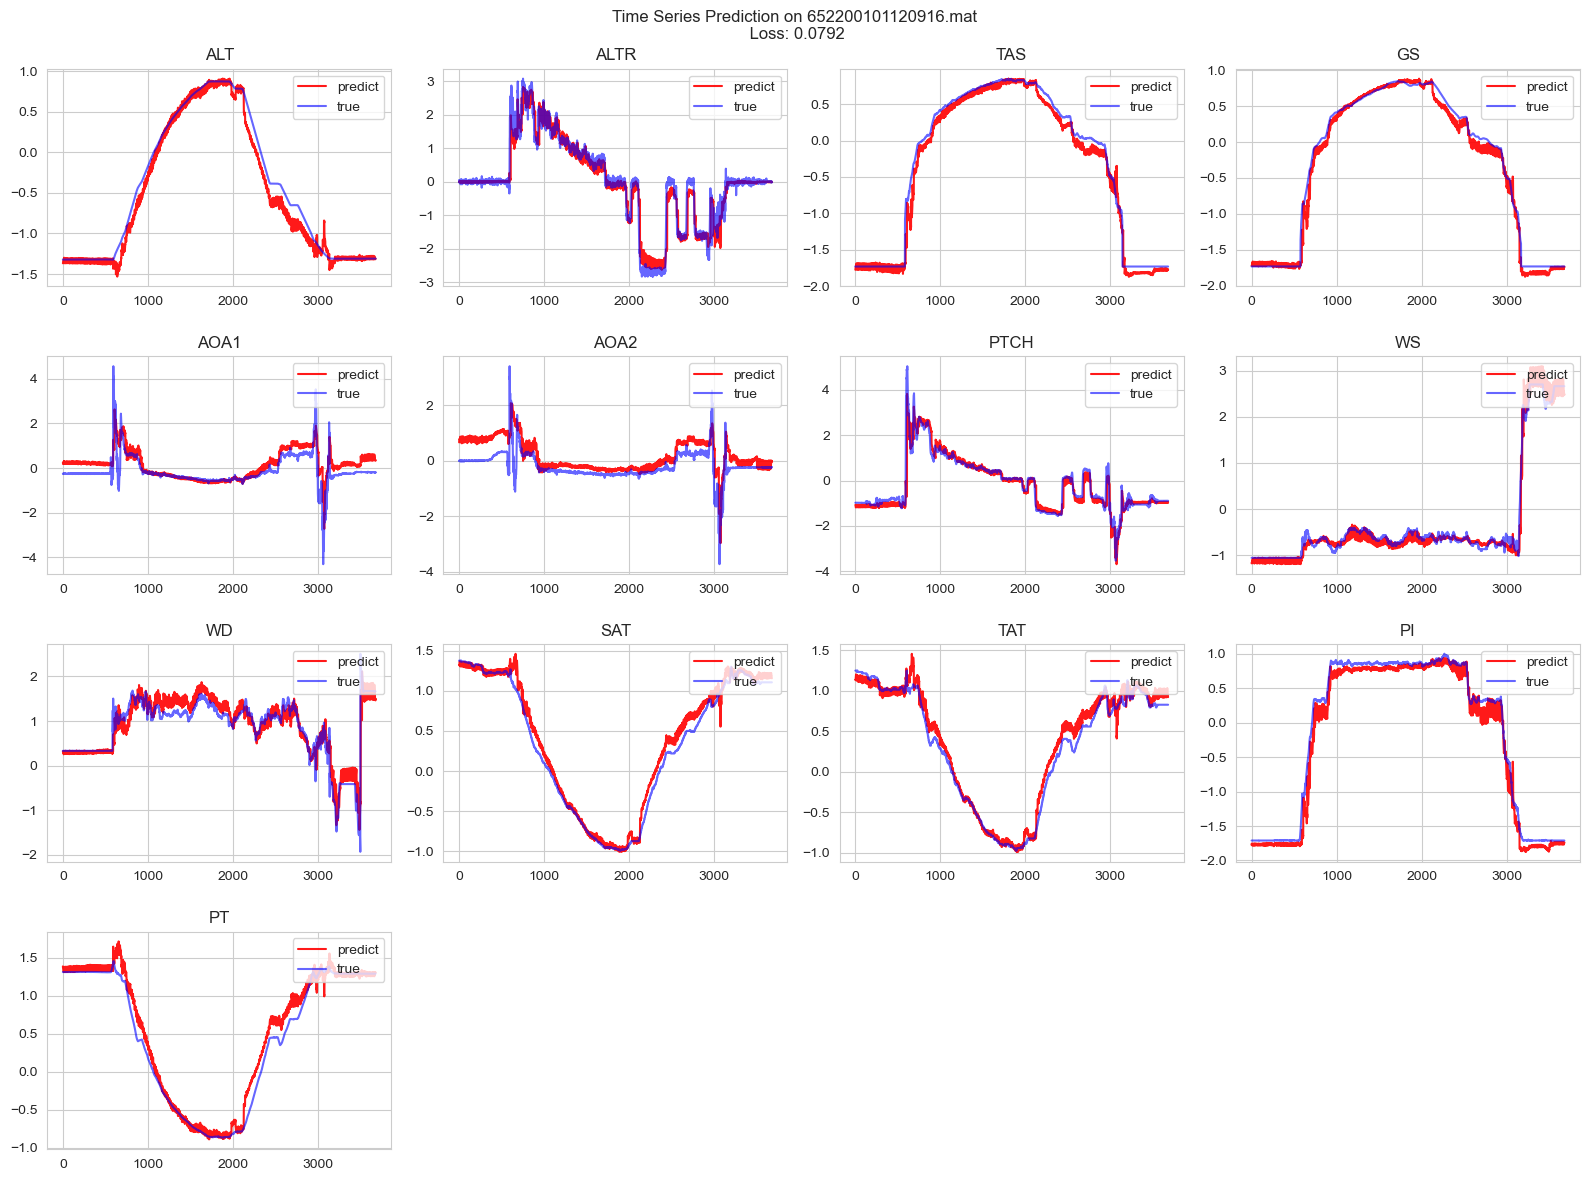

In [5]:
plot_predictions(MODEL, X_grouped, Y_grouped, var_names, mat_paths, iii=6,device=device)

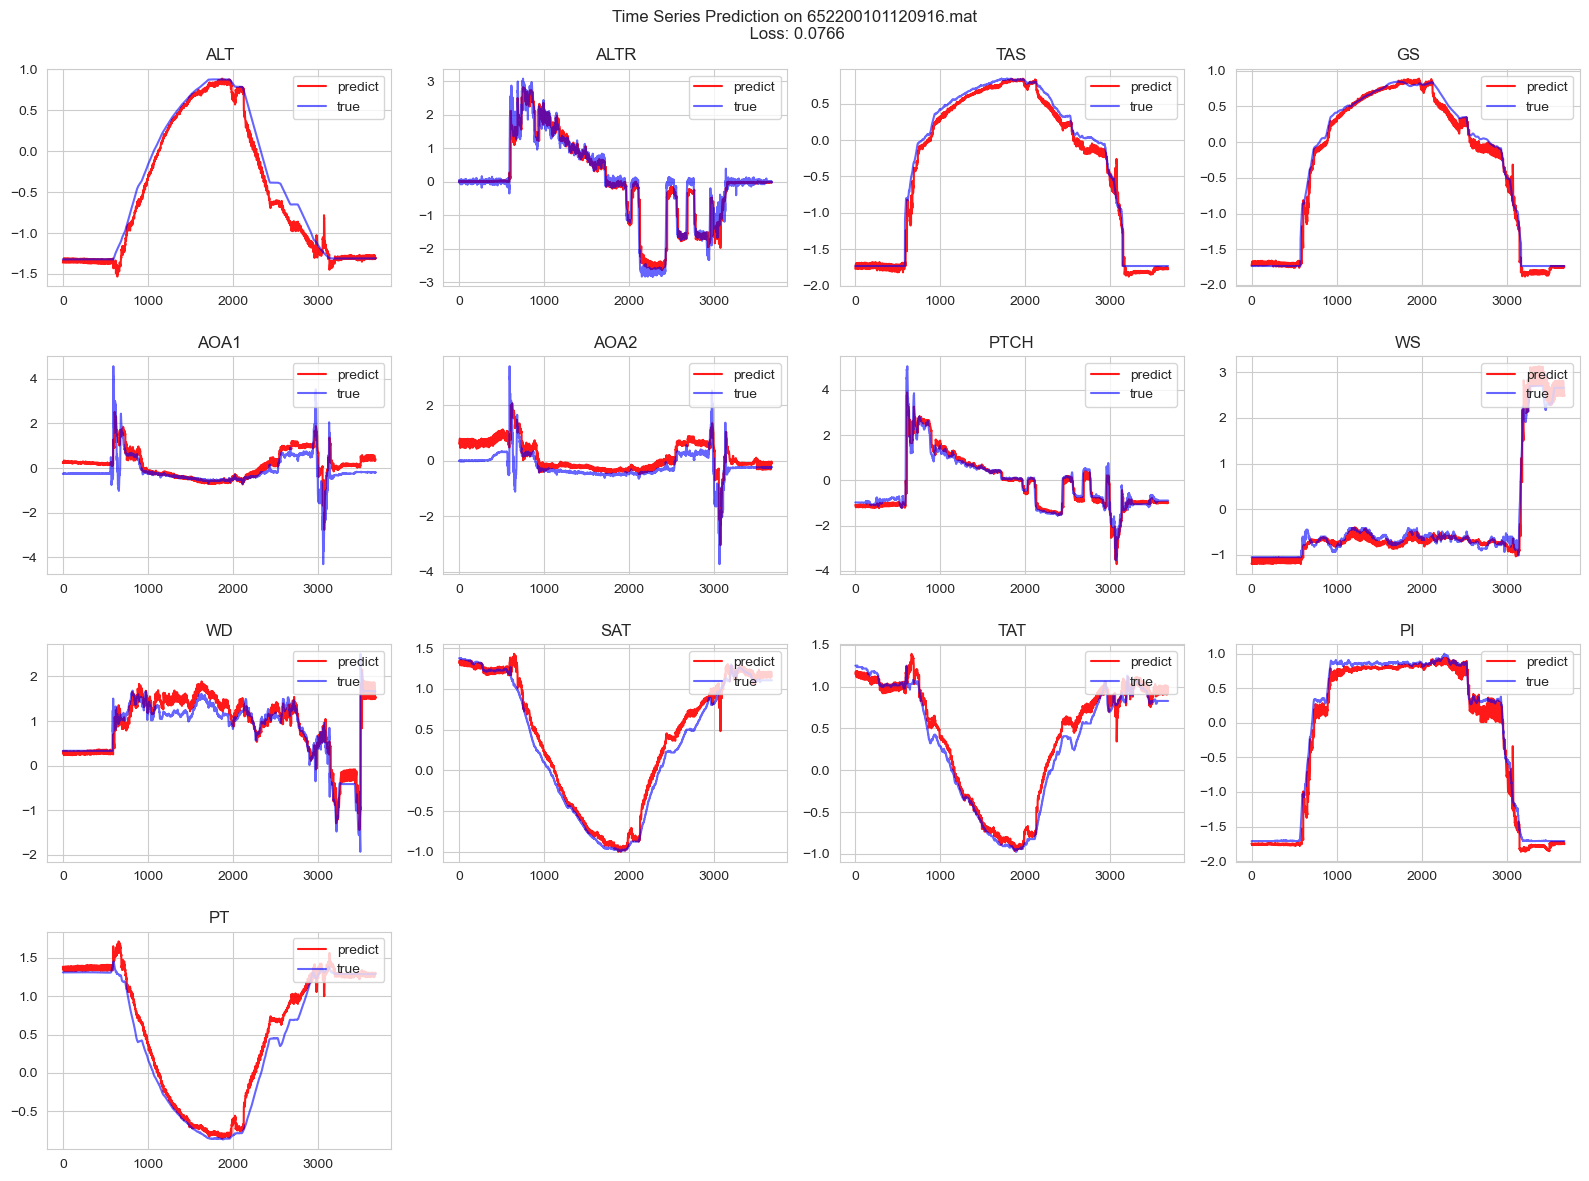

In [6]:
plot_predictions(MODEL, X_grouped, Y_grouped, var_names, mat_paths, iii=6,device=device)